In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_plot  import *
from colormap_c2c    import *


In [2]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'        ] = False
inputarray['save_figpath'    ] = '/home/ollie/pscholz/figures/poster_TRR181_winterschool/'


# set plot box for cyl projection (default: [-180,180,-90,90])
#inputarray['which_box'] = [0,360,-90,90] ; inputarray['mesh_focus']=180
inputarray['which_box'] = [-180,180,-90,90]
# inputarray['which_box'] = [-80,30,30,90]
#inputarray['which_box'] = [-90,35,20,85]
#inputarray['which_box'] = [-180,180,35,90]
#inputarray['which_box'] = [-180,180,-90,-50]
#inputarray['which_box'] = [-180,180,35,90]
# inputarray['which_box'] = [100,150,-20,20]

# set projection variable --> the lon/lat projection plot ranges are set via 
# inputarray['which_box'] = [lonmin,lonmax,latmin,latmax]
inputarray['proj'     ] = 'cyl' # 'ortho', 'cyl', 'npstere' , 'spstere'
inputarray['proj_lon' ] = -45 #only for ortho
inputarray['proj_lat' ] = 45 #only for ortho

inputarray['mesh_id'		 ] = 'COREv2'
inputarray['mesh_dir'		 ] = '/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_final/'
try:
	mesh
except NameError:
	mesh = fesom_init_mesh(inputarray)
else:
	print(" --> ___FOUND FESOM MESH --> will use it!___________________________")


___LOAD FESOM MESH_________________________________________
 --> read grid files
     > nod2d.out
     > elem2d.out
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> remove cyclic boundary
 --> calc landmask contourline
 --> rotate mesh geo2rot


In [15]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** SET INPUT PARAMETER ***                         |
#|                                                                             |
#+_____________________________________________________________________________+
# setup variable name, runid and data path
data 			= fesom_data(inputarray) # init fesom2.0 data object
# data.descript,data.path = 'zstar' , '../results/zstar/withoutPC-1/'
data.descript,data.path = 't_pgflinfs' , '../results/test_pgflinfs/'
data.var 		= 'pgfx'

data.crange     = [-1.0e-5,1.0e-5,0.0]
#data.crange     = [-2.0e-4,2.0e-4,0] # [cmin, cmax, cref]
#data.cmap       = 'rygbw'  
#data.cnumb      = 25

#+_____________________________________________________________________________+
# select year to average over [start_yr, end_yr]
# data.year		= [1998,2007]
#data.year		= [1990,2000]
data.year		= [1950,1950]

# select month to average over
data.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
#data.month		= [1,2,12]
#data.month		= [6,7,8]
# data.month		= [1,2,12]

# select linear interpolated depth layers to average over
# data.depth		= [0,10,20,30,40,50,75,100]
# data.depth		= np.arange(   0, 200+1,10)
data.depth		= np.arange( 200, 500+1,20)
# data.depth		= np.arange( 500,1000+1,50)
# data.depth		= np.arange(1000,1500+1,50)
# data.depth		= [50]
#data.depth		= np.arange(   3000, 5000+100,100)

#+_____________________________________________________________________________+
# make anomaly
# do_anomaly      = True
do_anomaly      = False
if do_anomaly==True:
    data2 			= cp.copy(data) # init fesom2.0 data object
    data2.descript,data2.path = 'pgflinfs','../results/test_pgflinfs'
    # data2.descript,data2.path = 'linfs','../results/linfs/withoutPC-1/'
	# data2.descript,data2.path = 'zstar','../results/zstar/withoutPC-1/'
	# data2.descript,data2.path = 'oldpc','../results/linfs/withPC-1/'
	# data2.descript,data2.path = 'zlevel','../results/zlevel/withoutPC-1/'
	# data2.descript,data2.path = 'zstar','../results/zstar/withoutPC-1/'
    
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM DATA ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# plot topography
if data.var=='depth':
	data.value 	= -mesh.nodes_2d_z
	#data.value 	= mesh.nodes_2d_iz
	data.sname, data.lname, data.unit, data.cmap = 'depth', 'Depth', 'm', 'wbgyr'
	data.levels = np.arange(0,np.max(data.value),200)# set resolution levels
#_______________________________________________________________________________
# plot triangle resolution interpolated to node
elif data.var=='triresol':
	if len(mesh.nodes_2d_resol)==0: mesh.fesom_calc_triresol()
	data.value 	= mesh.nodes_2d_resol
	data.sname, data.lname, data.unit, data.cmap = 'triresol', 'Resolution', 'km', 'odv'
	data.levels = np.arange(0,np.max(data.value),10)# set resolution levels
#_______________________________________________________________________________
# plot triangle area interpolated to node
elif data.var=='triarea':
	if len(mesh.nodes_2d_area)==0: mesh.fesom_calc_triarea()
	data.value 	= mesh.nodes_2d_area
	data.sname,data.lname, data.unit, data.cmap= 'triarea', 'Area', 'km^2', 'cmocean.cm.balance'
	data.levels = np.arange(0,np.max(data.value),10)# set resolution levels
#_______________________________________________________________________________
# load all other 2d and 3d variables
else:
	fesom_load_data_horiz(mesh,data,do_output='False')
	#if data.value.size == mesh.n2dea: data.value = mesh.fesom_interp_e2n(np.array(data.value))         
	if do_anomaly==True:
		fesom_load_data_horiz(mesh,data2,do_output='False')
		#if data2.value.size == mesh.n2dea: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
            
		#anom = fesom_data_anom(data,data2)
		anom = fesom_data_anom(data2,data)

     --> ../results/test_pgflinfs/
     --> pgfx



___PLOT 2D DATA____________________________________________


/home-nfs/ollie/pscholz/fvom_ALE_git/view_pscholz/sub_fesom_mesh.py:551: RuntimeWarning: invalid value encountered in true_divide
  data_n[0:self.n2dn]=data_n[0:self.n2dn]/self.nodes_2d_area[0:self.n2dn]/3.


<IPython.core.display.Javascript object>


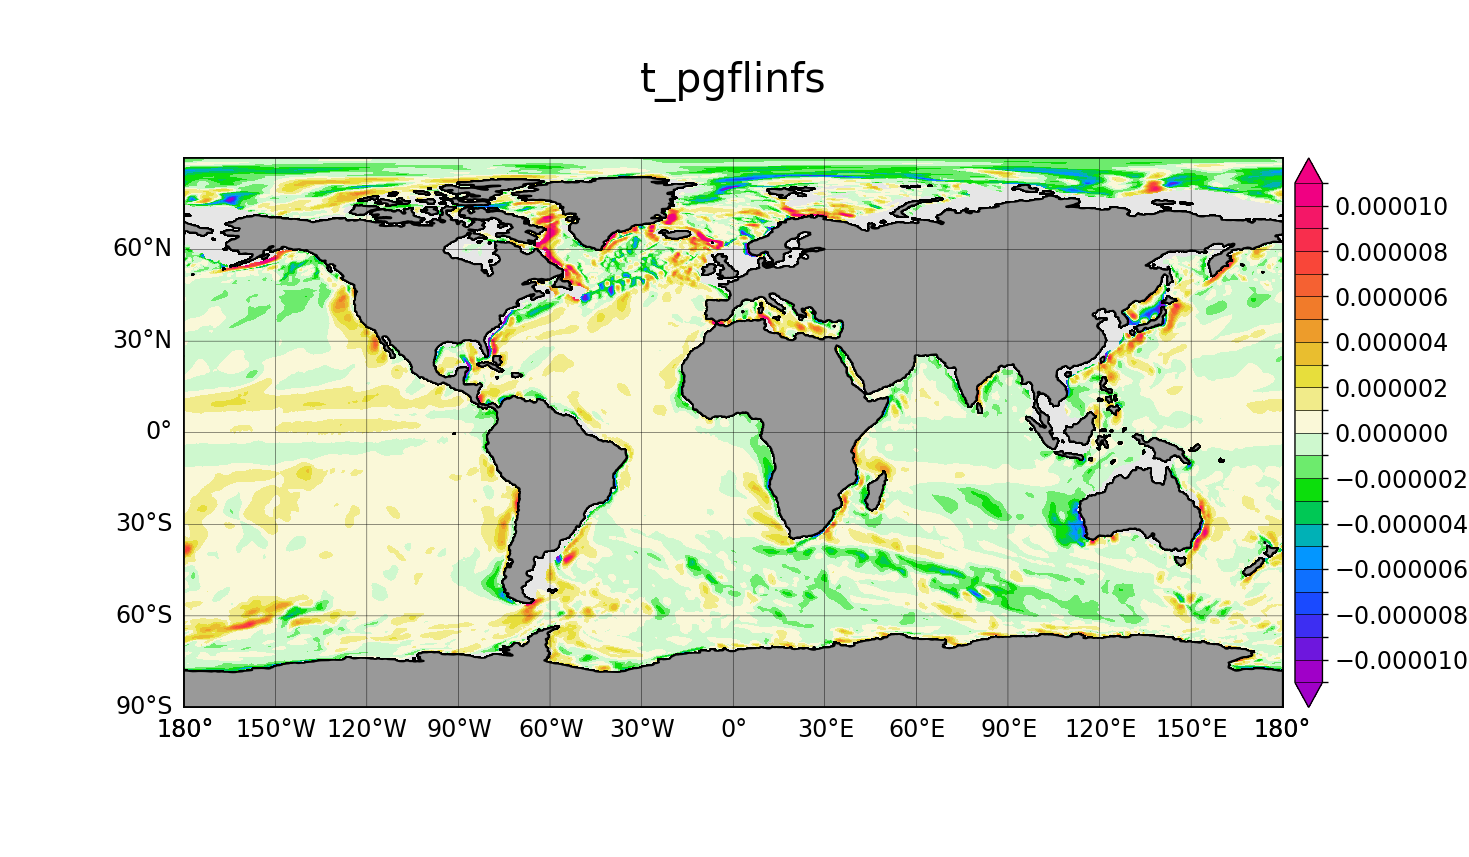

[cmin,cmax,cref] = [-1e-05, 1e-05, 0.0]
clevel =  [ -1.10000000e-05  -1.00000000e-05  -9.00000000e-06  -8.00000000e-06
  -7.00000000e-06  -6.00000000e-06  -5.00000000e-06  -4.00000000e-06
  -3.00000000e-06  -2.00000000e-06  -1.00000000e-06   0.00000000e+00
   1.00000000e-06   2.00000000e-06   3.00000000e-06   4.00000000e-06
   5.00000000e-06   6.00000000e-06   7.00000000e-06   8.00000000e-06
   9.00000000e-06   1.00000000e-05   1.10000000e-05]


/home-nfs/ollie/pscholz/fvom_ALE_git/view_pscholz/sub_fesom_plot.py:226: RuntimeWarning: invalid value encountered in less
  data_plot[data_plot<clevel[0]]  = clevel[0]+np.finfo(np.float32).eps
/home-nfs/ollie/pscholz/fvom_ALE_git/view_pscholz/sub_fesom_plot.py:227: RuntimeWarning: invalid value encountered in greater
  data_plot[data_plot>clevel[-1]] = clevel[-1]-np.finfo(np.float32).eps


In [16]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** PLOT FVSOM DATA ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# plot 2d and 2dvec data
if len(data.value2)==0:
	#___________________________________________________________________________
	# plot anomaly
	if do_anomaly==False:
		#_______________________________________________________________________
		if data.value.size == mesh.n2dea: data.value = mesh.fesom_interp_e2n(np.array(data.value))
		fig,ax,map,cbar=fesom_plot2d_data(mesh,data,figsize=[12,7])
	else:
		#_______________________________________________________________________
		# interpolate elemental values to nodal vlaues
		if data.value.size  == mesh.n2dea: data.value  = mesh.fesom_interp_e2n(np.array(data.value))
		if data2.value.size == mesh.n2dea: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
		if anom.value.size  == mesh.n2dea: anom.value  = mesh.fesom_interp_e2n(np.array(anom.value))
		
		#_______________________________________________________________________
		# do common crange for line and lin2
		cmax = np.max([np.nanmax(data.value),np.nanmax(data2.value)])
		cmin = np.min([np.nanmin(data.value),np.nanmin(data2.value)])
		cref = cmin + (cmax-cmin)/2
		cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
		data.crange = [cmin,cmax,cref]	
		data2.crange= [cmin,cmax,cref]
		
		#_______________________________________________________________________
		#fig,ax,map,cbar=fesom_plot2d_data(mesh,data,figsize=[12,7])
		#fig,ax,map,cbar=fesom_plot2d_data(mesh,data2,figsize=[12,7])
        
		#anom.crange=[-2e-2,2e-2,0]
		#anom.crange=[-2.5,2.5,0.0]
		#anom.crange=[-5e-4,5e-4,0.0]
		fig,ax,map,cbar=fesom_plot2d_data(mesh,anom,figsize=[12,7])
		
else:
	
	fesom_plot2dvec_data(mesh,data,figsize=[12,7])